# 1. Предобработка данных

## 1.1 Импорты

In [1]:
#pip install -U scikit-learn

In [2]:
#pip install catboost

In [3]:
#pip install numpy --upgrade

In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics


from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold

## 1.2 Загрузка данных

In [7]:
data_contract = pd.read_csv('contract.csv')
data_internet = pd.read_csv('internet.csv')
data_personal = pd.read_csv('personal.csv')
data_phone = pd.read_csv('phone.csv')

## 1.3 Первичный осмотр данных

### Контракты

Посмотрим на таблицу с контрактами

In [8]:
data_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [9]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [10]:
data_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [11]:
data_contract['customerID'].unique().size

7043

Видим, что:
   1. Каждый контракт заключен с уникальным пользователем
   2. Есть информация про 7043 пользователя
   2. Столбец TotalCharges имеет тип данных  object
   
Переведем данные столбца TotalCharges в числовой тип

In [12]:
data_contract['TotalCharges'] = pd.to_numeric(data_contract['TotalCharges'],errors = 'coerce')

In [13]:
data_contract[data_contract.isnull().any(axis=1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [14]:
data_contract = data_contract.dropna(axis=0, how='any')

In [15]:
data_contract[data_contract['BeginDate']=='2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


При изменении типа данных проблемы возникли с контратками, заключенными 2020-02-01. Так как такие контракты с точки зрения решения задачи не добавляют нам информации разумно будет их просто удалить

### Интернет

Посмотрим на таблицу с пользователями интернета

In [16]:
data_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [17]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [18]:
data_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9391-DXGGG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


1. Пропусков в данных нет
2. Каждая строчка это описание услуг для уникального пользователя
3. Интернет используют 5517 человек

### Телефонная связь

Посмотрим на таблицу с пользователями телефонной связи

In [19]:
data_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [20]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [21]:
data_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,9046-DQMTP,No
freq,1,3390


1. Пропусков в данных нет
2. Каждая строчка это описание услуг для уникального пользователя
3. Интернет используют 6361 человек

### Персональные данные

Посмотрим на персональные данные

In [22]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [23]:
data_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [24]:
data_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [25]:
data_personal['customerID'].unique().size

7043

1. Персональные данные приводтся для кадлонор пользователя, имеюшего контракт
2. Пропусков в данных нет

## Создание единого датафрейма

Объединим все данные в одну таблицу по столбцу customerID

In [26]:
data_all = data_contract.merge(data_internet,how='left', on='customerID').merge(
    data_phone, how='left', on='customerID').merge(
    data_personal, how='left', on='customerID')

In [27]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   5512 non-null   object 
 9   OnlineSecurity    5512 non-null   object 
 10  OnlineBackup      5512 non-null   object 
 11  DeviceProtection  5512 non-null   object 
 12  TechSupport       5512 non-null   object 
 13  StreamingTV       5512 non-null   object 
 14  StreamingMovies   5512 non-null   object 
 15  MultipleLines     6352 non-null   object 
 16  gender            7032 non-null   object 


В объединенной таблие появлиилсь порпуски, так как отличается ко-лво полтзовательт

In [29]:
internet_features = data_internet.drop(['customerID'], axis=1).columns
phone_features = data_phone.drop(['customerID'], axis=1).columns

In [30]:
data_all[internet_features] =  data_all[internet_features].fillna('no_internet')
data_all[phone_features] =  data_all[phone_features].fillna('no_phone')

In [31]:
data_all

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,no_phone,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,no_phone,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes
7028,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Female,0,Yes,Yes
7029,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,no_phone,Female,0,Yes,Yes
7030,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Yes,Male,1,Yes,No


## Выделение целевого признака

In [32]:
def target(x):
  if x == 'No':
    return 0
  else:
    return 1

In [33]:
data_all['Target'] = data_all['EndDate'].apply(target)

In [34]:
data_all['Target'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Target, dtype: float64

In [35]:
data_all['BeginDate'] = pd.to_datetime(data_all['BeginDate'], format='%Y-%m-%d')
data_all['EndDate'] = data_all['EndDate'].replace('No', '2020-02-01 00:00:00')
data_all['EndDate'] = pd.to_datetime(data_all['EndDate'], format='%Y-%m-%d %H:%M:%S')

# Анализ данных

## Визуализация данных и поиск взаимосвязей

In [36]:
telecom = data_all.copy()

In [37]:
telecom['Is_Internet'] = (telecom['OnlineSecurity'] !='no_internet')*1
telecom['Is_Phone'] = (telecom['MultipleLines'] !='no_phone')*1

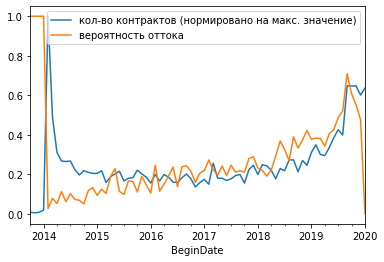

In [38]:
(telecom.groupby('BeginDate')['Target'].count()/np.max(telecom.groupby('BeginDate')['Target'].count())).plot(
    label='кол-во контрактов (нормировано на макс. значение)')
telecom.groupby('BeginDate')['Target'].mean().plot(label='вероятность оттока')
plt.legend()

In [39]:
telecom.groupby(['Is_Internet','Is_Phone'])['Target'].agg(['count','mean'])

count      mean
Is_Internet Is_Phone                 
0           1          1520  0.074342
1           0           680  0.250000
            1          4832  0.328228

### Количественные признаки

#### MonthlyCharges

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

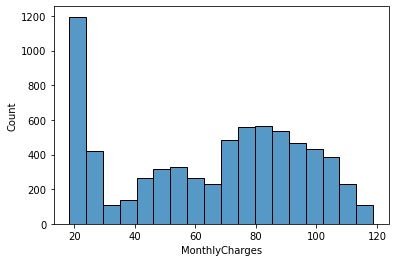

In [40]:
sns.histplot(telecom["MonthlyCharges"])

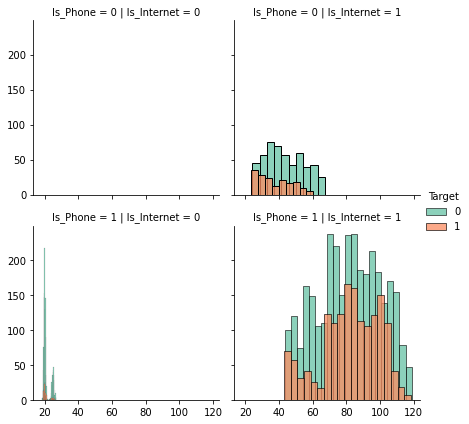

In [41]:
g = sns.FacetGrid(telecom, col="Is_Internet", row='Is_Phone', palette='Set2', hue='Target')
g.map_dataframe(sns.histplot, x="MonthlyCharges")
g.add_legend()

In [42]:
telecom.groupby(['Is_Internet', 'Target'])['MonthlyCharges'].agg(['count','mean'])

count       mean
Is_Internet Target                  
0           0        1407  21.133156
            1         113  20.368142
1           0        3756  76.356709
            1        1756  77.920985

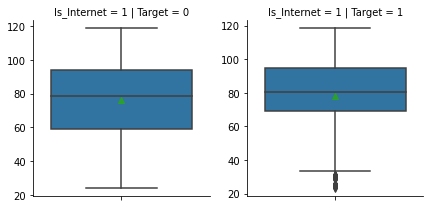

In [43]:
g = sns.FacetGrid(telecom[telecom['Is_Internet']==1], col="Target", row='Is_Internet', palette='Set2', sharey=False)#, hue='Target')
g.map_dataframe(sns.boxplot, y="MonthlyCharges", showmeans=True)
g.add_legend()

In [44]:
telecom['MonthlyCharges_q'] = pd.qcut(telecom[telecom['Is_Internet']==1]['MonthlyCharges'],10)

In [45]:
t = telecom.groupby('MonthlyCharges_q')[['Target']].agg(['count','mean'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

,Target_count,Target_mean
MonthlyCharges_q,,
"(23.448999999999998, 45.4]",554,0.323105
"(45.4, 55.0]",551,0.268603
"(55.0, 65.6]",550,0.145455
"(65.6, 73.85]",559,0.330948
"(73.85, 79.5]",550,0.401818
"(79.5, 84.9]",545,0.357798
"(84.9, 90.6]",550,0.369091
"(90.6, 97.69]",550,0.370909
"(97.69, 104.7]",554,0.400722


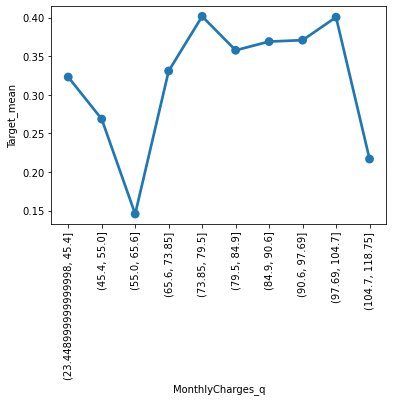

In [46]:
sns.pointplot(data = t, x=t.index, y='Target_mean')
degrees = 90
plt.xticks( rotation = degrees)
plt.show()

#### TotalCharges

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

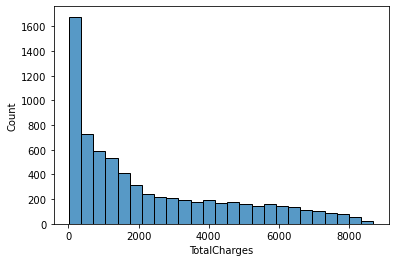

In [47]:
sns.histplot(telecom["TotalCharges"])

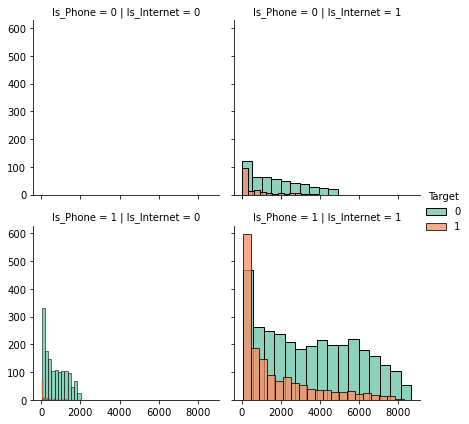

In [48]:
g = sns.FacetGrid(telecom, col="Is_Internet", row='Is_Phone', palette='Set2', hue='Target')
g.map_dataframe(sns.histplot, x="TotalCharges")
g.add_legend()

In [49]:
telecom.groupby(['Is_Internet', 'Target'])['TotalCharges'].agg(['count','mean'])

count         mean
Is_Internet Target                    
0           0        1407   704.678003
            1         113   173.919912
1           0        3756  3248.604859
            1        1756  1619.176509

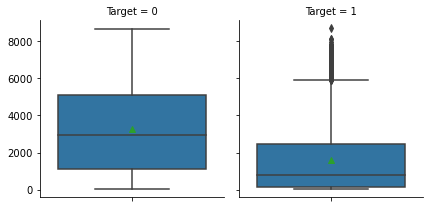

In [50]:
g = sns.FacetGrid(telecom[telecom['Is_Internet']==1], col="Target", palette='Set2')#, hue='Target')
g.map_dataframe(sns.boxplot, y="TotalCharges", showmeans=True)
g.add_legend()

In [51]:
telecom['TotalCharges_q'] = pd.qcut(telecom[telecom['Is_Internet']==1]['TotalCharges'],10)

In [52]:
t = telecom.groupby('TotalCharges_q')[['Target']].agg(['count','mean'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

,Target_count,Target_mean
TotalCharges_q,,
"(23.448999999999998, 118.31]",552,0.686594
"(118.31, 392.53]",551,0.511797
"(392.53, 830.815]",551,0.411978
"(830.815, 1406.26]",551,0.381125
"(1406.26, 2139.15]",551,0.272232
"(2139.15, 2997.78]",551,0.286751
"(2997.78, 3987.555]",551,0.192377
"(3987.555, 5063.74]",551,0.166969
"(5063.74, 6365.16]",551,0.154265


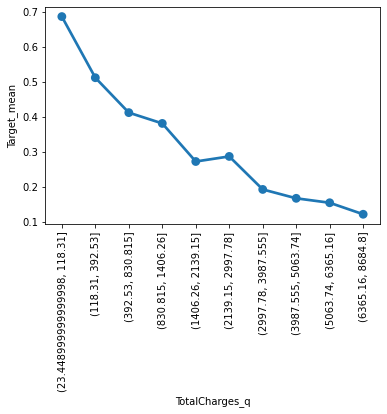

In [53]:
sns.pointplot(data = t, x=t.index, y='Target_mean')
degrees = 90
plt.xticks( rotation = degrees)
plt.show()

####   Взаимосвязь между признаками

In [54]:
telecom[['MonthlyCharges', 'TotalCharges']].corr()

,MonthlyCharges,TotalCharges
MonthlyCharges,1.000000,0.651065
TotalCharges,0.651065,1.000000


In [55]:
telecom['BeginYear'] = pd.DatetimeIndex(telecom['BeginDate']).year
telecom['BeginMonth'] = pd.DatetimeIndex(telecom['BeginDate']).month

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

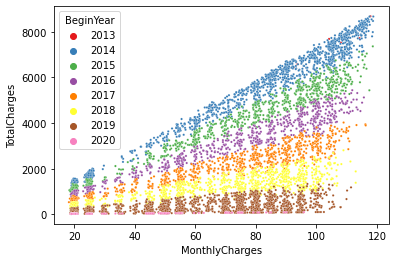

In [56]:
sns.scatterplot(x="MonthlyCharges", y="TotalCharges", data=telecom.sort_values(
    by='BeginYear'), s=5, hue='BeginYear', palette = 'Set1')

In [57]:
t =telecom.groupby('BeginYear')[['MonthlyCharges', 'TotalCharges']].corr().reset_index(
    level=[0,1]).set_index('BeginYear')

In [58]:
t[t['level_1']=='MonthlyCharges'][['level_1', 'TotalCharges']]

,level_1,TotalCharges
BeginYear,,
2013,MonthlyCharges,0.980256
2014,MonthlyCharges,0.990412
2015,MonthlyCharges,0.984461
2016,MonthlyCharges,0.978015
2017,MonthlyCharges,0.952701
2018,MonthlyCharges,0.873363
2019,MonthlyCharges,0.510660
2020,MonthlyCharges,1.000000


### Категориальные признаки

#### Type, PaperlessBilling, PaymentMethod, gender

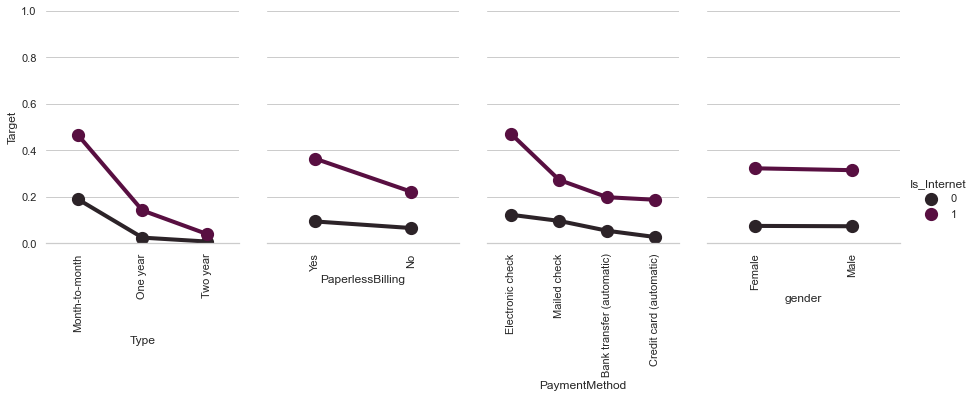

In [59]:
sns.set_theme(style="whitegrid")

g = sns.PairGrid(telecom, y_vars="Target",
                 x_vars=['Type','PaperlessBilling','PaymentMethod', 'gender'],
                 height=4, aspect=0.8, hue='Is_Internet')

g.map(sns.pointplot, scale=1.5, errwidth=0, color="xkcd:plum")
g.add_legend()

for ax in g.axes.flatten():
    # rotate x axis labels
    ax.tick_params(axis='x', rotation=90)

degrees = 90
plt.xticks( rotation = degrees)
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)


#### InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV,	StreamingMovies

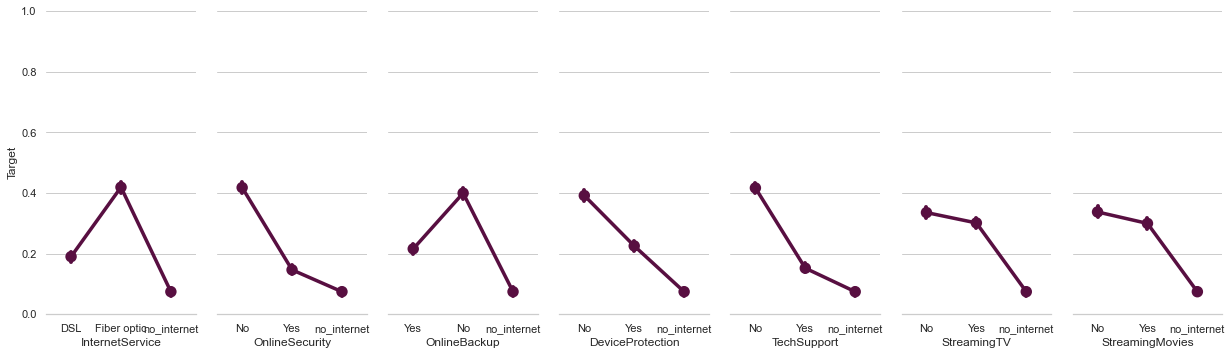

In [60]:
sns.set_theme(style="whitegrid")

# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(telecom, y_vars="Target",
                 x_vars=['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',	'StreamingMovies'],
                 height=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=4, color="xkcd:plum")
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

In [61]:
telecom = telecom.replace(['Yes', 'No', 'no_internet'],[1, 0, 100])

In [62]:
telecom_only_internet = telecom[telecom['InternetService']!=100]

<AxesSubplot:xlabel='StreamingTV', ylabel='StreamingMovies'>

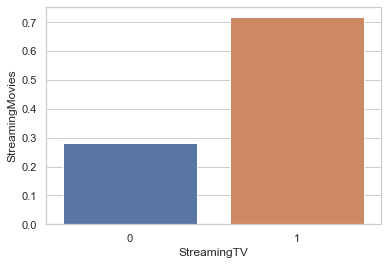

In [63]:
gr3 = telecom_only_internet.groupby('StreamingTV')[['StreamingMovies']].mean()
sns.barplot(x = gr3.index, y= 'StreamingMovies', data = gr3)

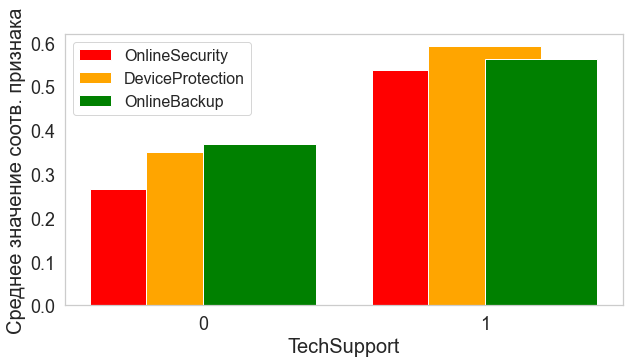

In [64]:
gr1= telecom_only_internet.groupby('TechSupport')[['OnlineSecurity', 'DeviceProtection', 'OnlineBackup']].mean()
X = gr1.index
X_axis = np.arange(len(X))

figure_name = plt.figure(figsize=(10, 5))

color_dict = {'OnlineSecurity':'red', 'DeviceProtection': 'orange', 'OnlineBackup':'green'}

for i in range(len(gr1.columns)):
    plt.bar(X_axis + (-0.2 +i*0.2), gr1[gr1.columns[i]], 0.4, label = gr1.columns[i], color = color_dict[gr1.columns[i]])

plt.xticks(X_axis, X)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.xlabel('TechSupport', fontsize = 20)
plt.ylabel("Среднее значение соотв. признака", fontsize = 20)
plt.legend(fontsize = 16)
plt.grid()
plt.show()


#### SeniorCitizen, Partner,	Dependents

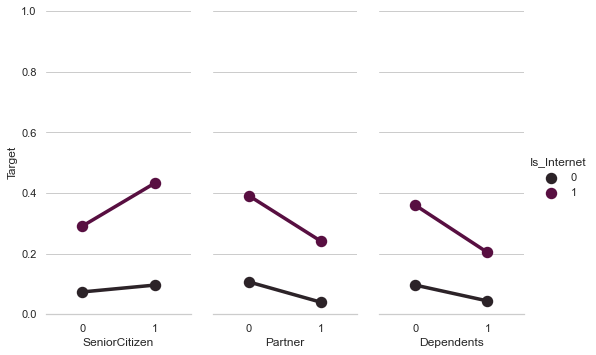

In [65]:
sns.set_theme(style="whitegrid")

# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(telecom, y_vars="Target",
                 x_vars=['SeniorCitizen',	'Partner',	'Dependents'],
                 height=5, aspect=.5, hue='Is_Internet')

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=0, color="xkcd:plum")
g.set(ylim=(0, 1))
g.add_legend()
sns.despine(fig=g.fig, left=True)


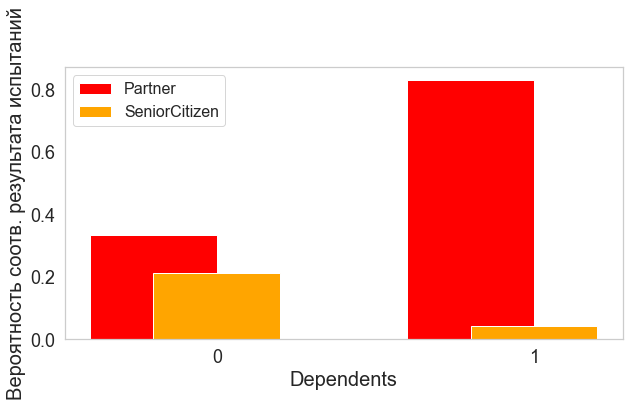

In [66]:
gr2 = telecom.groupby('Dependents')[['Partner','SeniorCitizen']].mean()
X = gr2.index
X_axis = np.arange(len(X))

figure_name = plt.figure(figsize=(10, 5))

color_dict = {'Partner':'red', 'SeniorCitizen': 'orange'}

for i in range(len(gr2.columns)):
  plt.bar(X_axis + (-0.2 +i*0.2), gr2[gr2.columns[i]], 0.4, label = gr2.columns[i], color = color_dict[gr2.columns[i]])
  
plt.xticks(X_axis, X)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.xlabel("Dependents", fontsize = 20)
plt.ylabel("Вероятность соотв. результата испытаний", fontsize = 20)
plt.legend(fontsize = 16)
plt.grid()
plt.show()


## Экспериментирование с комбинациями признаков

### ClientLifetime

In [67]:
pd.DatetimeIndex(telecom['BeginDate']).day.value_counts()

1    7032
Name: BeginDate, dtype: int64

In [68]:
telecom['ClientLifetime_D'] = round((telecom['EndDate'] - telecom['BeginDate'])/np.timedelta64(1,'D'),1)
telecom['ClientLifetime_M'] = round((telecom['EndDate'] - telecom['BeginDate'])/np.timedelta64(1,'M'),1)

<AxesSubplot:xlabel='ClientLifetime_M', ylabel='Count'>

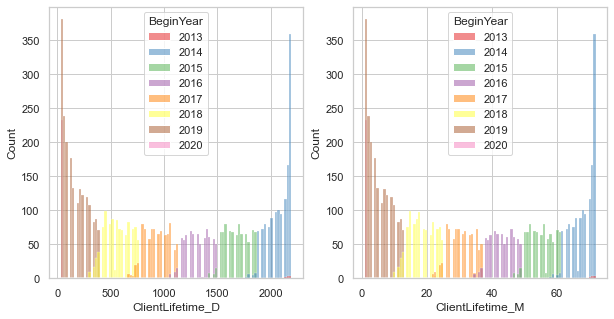

In [69]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.histplot(data = telecom, x='ClientLifetime_D', bins = 100, hue='BeginYear', palette = 'Set1', ax=axs[0])
sns.histplot(data = telecom, x='ClientLifetime_M', bins = 100, hue='BeginYear', palette = 'Set1', ax=axs[1])

In [70]:
telecom.query('ClientLifetime_M<=10').groupby(['ClientLifetime_M','ClientLifetime_D'])['Target'].agg(['count','mean'])

count      mean
ClientLifetime_M ClientLifetime_D                 
1.0              30.0                182  1.000000
                 31.0                431  0.459397
2.0              61.0                123  1.000000
                 62.0                115  0.000000
3.0              91.0                 31  1.000000
                 92.0                169  0.372781
4.0              122.0                58  1.000000
                 123.0               118  0.211864
5.0              153.0               133  0.481203
6.0              183.0                14  1.000000
                 184.0                96  0.270833
7.0              214.0                51  1.000000
7.1              215.0                80  0.000000
8.0              242.0                13  1.000000
                 244.0                 8  1.000000
                 245.0               102  0.205882
9.0              273.0                31  1.000000
                 275.0                15  1.000000
9.1              276.0                73  0.000000
10.0             303.0                10  1.000000
                 304.0                25  1.000000

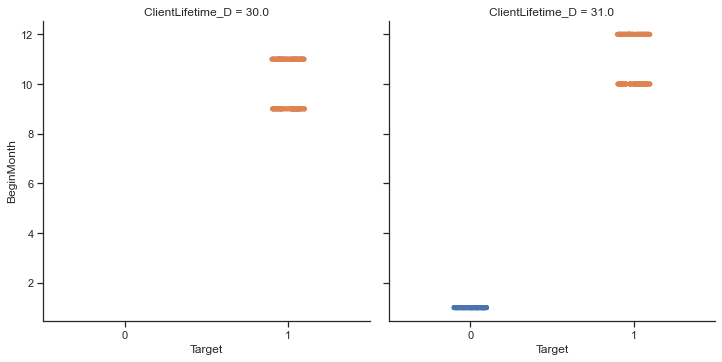

In [71]:
sns.set_theme(style="ticks")
g = sns.catplot(x="Target", y="BeginMonth", col="ClientLifetime_D", data=telecom.query('ClientLifetime_M==1'))

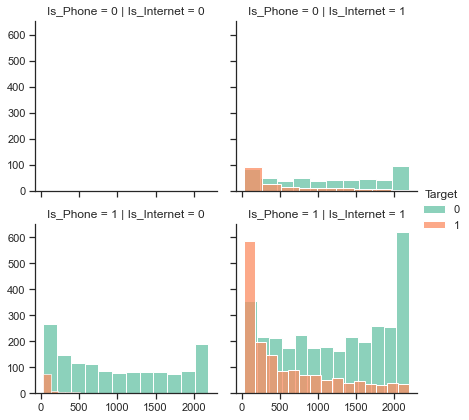

In [72]:
g = sns.FacetGrid(telecom, col="Is_Internet", row='Is_Phone', palette='Set2', hue='Target')
g.map_dataframe(sns.histplot, x="ClientLifetime_D")
g.add_legend()

In [73]:
telecom.groupby(['Is_Internet', 'Target'])['ClientLifetime_D'].agg(['count','mean'])

count         mean
Is_Internet Target                    
0           0        1407   989.196873
            1         113   250.840708
1           0        3756  1205.955804
            1        1756   566.432802

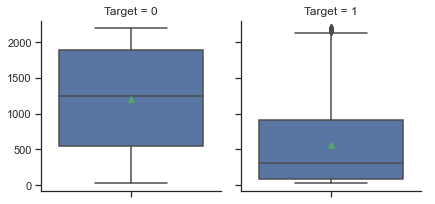

In [74]:
g = sns.FacetGrid(telecom[telecom['Is_Internet']==1], col="Target", palette='Set2')#, hue='Target')
g.map_dataframe(sns.boxplot, y='ClientLifetime_D', showmeans=True)
g.add_legend()

In [75]:
telecom['ClientLifetime_D_q'] = pd.qcut(telecom[telecom['Is_Internet']==1]['ClientLifetime_D'],10)

In [76]:
t = telecom.groupby('ClientLifetime_D_q')[['Target']].agg(['count','mean'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

,Target_count,Target_mean
ClientLifetime_D_q,,
"(29.999, 61.0]",564,0.778369
"(61.0, 184.0]",561,0.475936
"(184.0, 365.0]",543,0.440147
"(365.0, 640.0]",545,0.407339
"(640.0, 914.0]",582,0.264605
"(914.0, 1248.0]",565,0.270796
"(1248.0, 1553.0]",514,0.210117
"(1553.0, 1857.0]",567,0.156966
"(1857.0, 2102.0]",547,0.113346


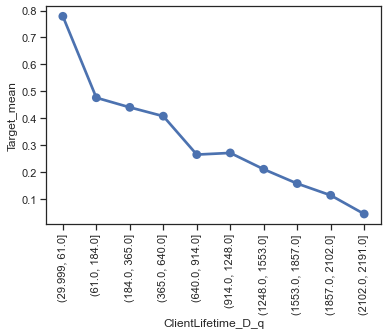

In [77]:
sns.pointplot(data = t, x=t.index, y='Target_mean')
degrees = 90
plt.xticks( rotation = degrees)
plt.show()

/Users/x_ray_serg/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


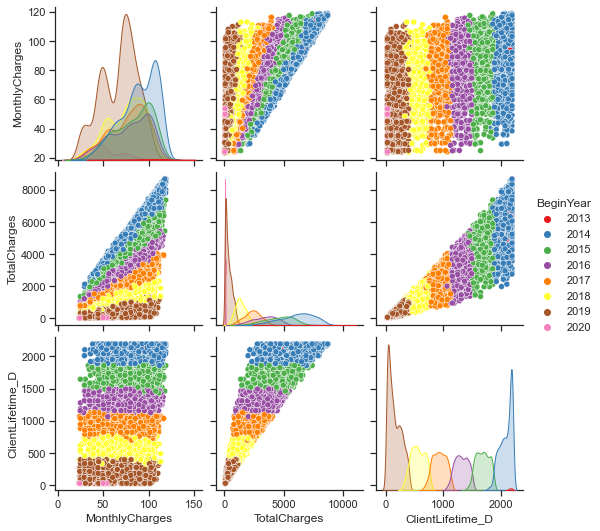

In [78]:
g = sns.pairplot(telecom.query('Is_Internet==1')[['MonthlyCharges','TotalCharges', 'ClientLifetime_D','BeginYear']],
                 hue = 'BeginYear', palette = 'Set1')#, y_vars="Target",
                 #x_vars=['Type','PaperlessBilling','PaymentMethod', 'gender'],
                 #height=4, aspect=0.8, hue='Is_Internet')


## Оценки взаимосвязи признаков с целевым признаком. Проверка мультиколлинеарности

### Числовые признаки

In [79]:
telecom['rand_int'] = np.random.rand(len(telecom))

In [80]:
telecom.groupby('Target')['rand_int'].mean()

Target
0    0.496417
1    0.506129
Name: rand_int, dtype: float64

In [81]:
columns_list = ['MonthlyCharges', 'TotalCharges', 'ClientLifetime_D', 'ClientLifetime_M', 'rand_int']

In [82]:
tt_value = []
p_value = []

for i in columns_list:
    tt_test = stats.ttest_ind(telecom[(telecom['Target']==0) & (telecom['Is_Internet']==1)][i], 
                              telecom[(telecom['Target']==1) & (telecom['Is_Internet']==1)][i], axis=0, equal_var=False)
    tt_value.append(tt_test[0])
    p_value.append(tt_test[1])
values = pd.DataFrame({'column': columns_list, 'tt_value':tt_value,  'p_value':p_value}).sort_values(by='p_value',
                                                                                                    ascending=False)
values['p_crit'] = 0.05


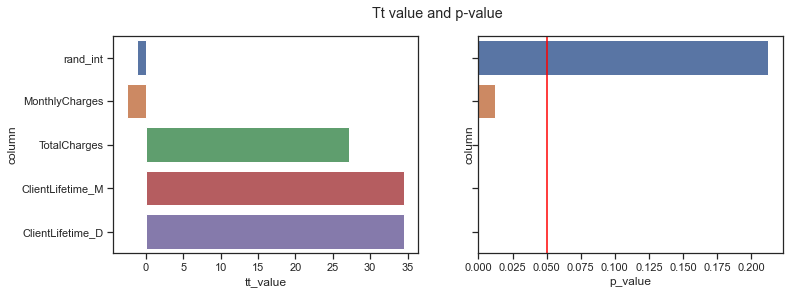

In [83]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,4))
fig.suptitle('Tt value and p-value')
sns.barplot(ax=ax[0], x='tt_value', y='column', data= values)
g=sns.barplot(ax=ax[1], x='p_value', y='column', data= values)
g.axvline(0.05, color='red')

<AxesSubplot:>

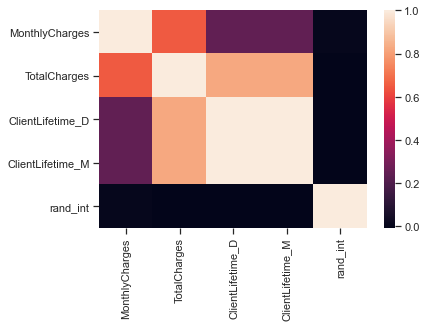

In [84]:
t = telecom[['MonthlyCharges','TotalCharges', 'ClientLifetime_D','ClientLifetime_M',  'rand_int']].corr()
sns.heatmap(t)

 Оставляем 'MonthlyCharges' и 'ClientLifetime_D'/'ClientLifetime_M'

In [85]:
num_features_stat_selected = ['MonthlyCharges', 'ClientLifetime_D', 'ClientLifetime_M']

### Категориальные признаки

In [86]:
telecom['rand_bin'] = np.random.randint(2, size=len(telecom))

In [87]:
telecom.groupby('Target')['rand_bin'].mean()

Target
0    0.495836
1    0.499197
Name: rand_bin, dtype: float64

In [88]:
def cramers(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    p = chi2_contingency(confusion_matrix)[1]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return chi2, p, np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

<AxesSubplot:>

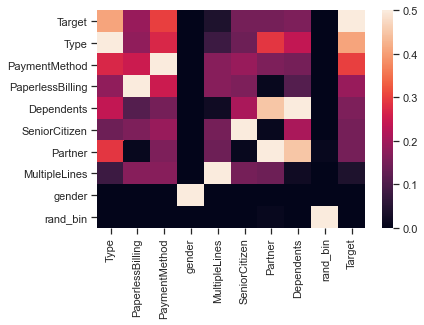

In [89]:
import numpy as np
column_list=['Type',	'PaperlessBilling'	,'PaymentMethod', 'gender', 'MultipleLines', 'SeniorCitizen',	'Partner',	'Dependents', 'rand_bin', 'Target']
cramer_all_value = np.zeros([len(column_list), len(column_list)])
for i in range(len(column_list)):
  for j in range(len(column_list)):
    result = cramers(telecom[column_list[i]], telecom[column_list[j]])
    cramer_all_value[i,j]=round(result[2],2)

cramer_all_value = pd.DataFrame(cramer_all_value, columns = column_list, index = column_list )
sns.heatmap(cramer_all_value.sort_values(by='Target',ascending=False), vmax=0.5)

In [90]:
cramer_all_value['Target'].sort_values(ascending=False)

Target              1.00
Type                0.41
PaymentMethod       0.30
PaperlessBilling    0.19
Dependents          0.16
SeniorCitizen       0.15
Partner             0.15
MultipleLines       0.04
gender              0.00
rand_bin            0.00
Name: Target, dtype: float64

<AxesSubplot:>

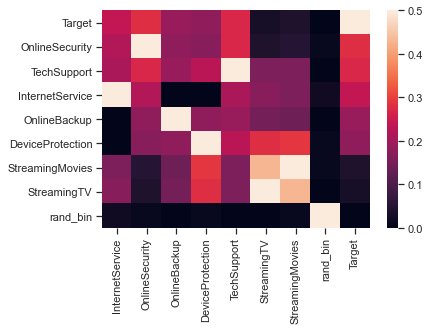

In [91]:
column_list=['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport', 'StreamingTV','StreamingMovies','rand_bin','Target']
cramer_all_value = np.zeros([len(column_list), len(column_list)])
for i in range(len(column_list)):
  for j in range(len(column_list)):
    result = cramers(telecom.query('Is_Internet==1')[column_list[i]], telecom.query('Is_Internet==1')[column_list[j]])
    cramer_all_value[i,j]=round(result[2],2)

cramer_all_value = pd.DataFrame(cramer_all_value, columns = column_list, index = column_list)
sns.heatmap(cramer_all_value.sort_values(by='Target',ascending=False), vmax=0.5)

In [92]:
cramer_all_value['Target'].sort_values(ascending=False)

Target              1.00
OnlineSecurity      0.28
TechSupport         0.27
InternetService     0.24
OnlineBackup        0.19
DeviceProtection    0.18
StreamingMovies     0.04
StreamingTV         0.03
rand_bin            0.00
Name: Target, dtype: float64

In [93]:
cat_features_stat_selected = ['Type', 'PaymentMethod', 
                              'PaperlessBilling', 'Dependents', 'OnlineSecurity', 'TechSupport',
                             'InternetService', 'OnlineBackup', 'DeviceProtection']

# Подготовка данных для алгортимов машинного обучения

## Формирование датасетов train и test

In [94]:
data_all['ClientLifetime_D'] = round((data_all['EndDate'] - data_all['BeginDate'])/np.timedelta64(1,'D'),1)
data_all['ClientLifetime_M'] = round((data_all['EndDate'] - data_all['BeginDate'])/np.timedelta64(1,'M'),1)

In [95]:
X = data_all.drop(['customerID','BeginDate','EndDate','Target'], axis = 1)
y = data_all['Target']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [97]:
features_stat_selected = num_features_stat_selected + cat_features_stat_selected

In [98]:
X_train, X_test = X_train[features_stat_selected], X_test[features_stat_selected]

In [99]:
X_test.columns

Index(['MonthlyCharges', 'ClientLifetime_D', 'ClientLifetime_M', 'Type',
       'PaymentMethod', 'PaperlessBilling', 'Dependents', 'OnlineSecurity',
       'TechSupport', 'InternetService', 'OnlineBackup', 'DeviceProtection'],
      dtype='object')

## Cоздание новых признаков

In [100]:
class Choose_features(BaseEstimator, TransformerMixin):
  def __init__(self, lifetime_month):
    # Оставляем или ClientLifetime_D или ClientLifetime_M
    self.lifetime_month = lifetime_month
  def fit(self, X, y= None):
    return self
  def transform(self, X, y= None):
    df=pd.DataFrame(X).copy()    
    if self.lifetime_month: 
      df = df.drop(['ClientLifetime_D'], axis=1).copy()
    else:
      df = df.drop(['ClientLifetime_M'], axis=1).copy()
    return df 

## Обработка признаков

In [101]:
# Выполняем для того, чтобы после кодировки не оставались одинаковое столбцы , там где мы заполняли пропуски no_internet
class Prepare_columns(BaseEstimator, TransformerMixin):
  def __init__(self, prepare_columns=True):
    self.prepare_columns = prepare_columns
  def fit(self, X, y= None):
    return self
  def transform(self, X, y= None):
    df=pd.DataFrame(X).copy()
    if self.prepare_columns:
      df['no_internet'] = (df[list(set(data_internet.columns.tolist()) & set(features_stat_selected))[1]] == 'no_internet')*1
      df = df.replace(['Yes', 'No', 'no_internet'],[1, 0, 0])
      df = df.replace(['Fiber optic', 'DSL'],[1, 0])
    return df

In [102]:
cat_transformer = Pipeline([('onehot', OneHotEncoder(drop='first'))])
num_transformer = Pipeline([('scaler', StandardScaler())])

In [103]:
col_transform = ColumnTransformer([
        ('cat', cat_transformer, make_column_selector(dtype_include=object)),
        ('num', num_transformer, make_column_selector(dtype_include=np.number))])

In [104]:
preprocessor = Pipeline([('Prepare', Prepare_columns()),
                         ('Choose', Choose_features(lifetime_month=False)),
                          ('Transform', col_transform)])

In [105]:
preprocessor.fit_transform(X_train)

array([[ 0.        ,  1.        ,  1.        , ...,  1.36157309,
         1.37605179, -0.52296156],
       [ 0.        ,  0.        ,  0.        , ..., -0.7344446 ,
         1.37605179, -0.52296156],
       [ 0.        ,  1.        ,  1.        , ...,  1.36157309,
         1.37605179, -0.52296156],
       ...,
       [ 0.        ,  1.        ,  1.        , ...,  1.36157309,
         1.37605179, -0.52296156],
       [ 1.        ,  0.        ,  0.        , ...,  1.36157309,
         1.37605179, -0.52296156],
       [ 0.        ,  0.        ,  0.        , ..., -0.7344446 ,
        -0.72671684, -0.52296156]])

In [106]:
col_transform.get_feature_names_out()

array(['cat__Type_One year', 'cat__Type_Two year',
       'cat__PaymentMethod_Credit card (automatic)',
       'cat__PaymentMethod_Electronic check',
       'cat__PaymentMethod_Mailed check', 'num__MonthlyCharges',
       'num__ClientLifetime_D', 'num__PaperlessBilling',
       'num__Dependents', 'num__OnlineSecurity', 'num__TechSupport',
       'num__InternetService', 'num__OnlineBackup',
       'num__DeviceProtection', 'num__no_internet'], dtype=object)

# Выбор, обучение и точная настройка моделей

##  Baseline

In [107]:
y_pred_2 = np.random.rand(len(X_test))
roc_auc_2  = roc_auc_score(y_test, y_pred_2)
round(roc_auc_2,3)

0.51

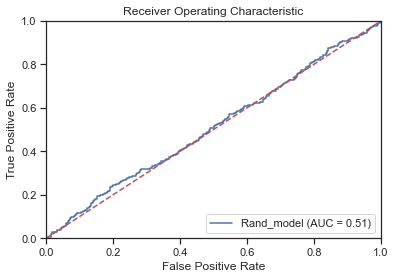

In [108]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_2)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Rand_model (AUC = %0.2f)' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Логистическая регрессия

In [109]:
lr = Pipeline([('prep', preprocessor),
            ('clf', LogisticRegression())])

In [110]:
param_grid_lr = {
    "prep__Choose__lifetime_month": [True, False],
    "clf__C": [0.1, 1.0, 10]}

In [111]:
kfolds = StratifiedKFold(5, shuffle=True, random_state =10)

In [112]:
grid_search_lr = GridSearchCV(lr, param_grid_lr,scoring='roc_auc', cv=kfolds.split(X_train, y_train))

In [113]:
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fba1c341190>,
             estimator=Pipeline(steps=[('prep',
                                        Pipeline(steps=[('Prepare',
                                                         Prepare_columns()),
                                                        ('Choose',
                                                         Choose_features(lifetime_month=False)),
                                                        ('Transform',
                                                         ColumnTransformer(transformers=[('cat',
                                                                                          Pipeline(steps=[('onehot',
                                                                                                           OneHotEncoder(drop='first'))]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9f99fa790>),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fba1c0ff6d0>)]))])),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.1, 1.0, 10],
                         'prep__Choose__lifetime_month': [True, False]},
             scoring='roc_auc')

In [114]:
round(grid_search_lr.best_score_,3)

0.842

In [115]:
grid_search_lr.best_params_

{'clf__C': 1.0, 'prep__Choose__lifetime_month': False}

In [116]:
cv_results_lr = pd.DataFrame(grid_search_lr.cv_results_)
cv_results_lr[["mean_test_score", 'param_clf__C', 'param_prep__Choose__lifetime_month']].sort_values(by='mean_test_score', ascending = False).head(10)

,mean_test_score,param_clf__C,param_prep__Choose__lifetime_month
3,0.842214,1.0,False
5,0.842206,10,False
4,0.842179,10,True
2,0.842175,1.0,True
1,0.841688,0.1,False
0,0.841648,0.1,True


In [117]:
round(grid_search_lr.score(X_train, y_train),3)

0.845

## Случайный лес

In [118]:
rf = Pipeline([('prep', preprocessor),
            ('clf', RandomForestClassifier(random_state=42))])

In [119]:
param_grid_rf = {
    "prep__Choose__lifetime_month": [True, False],
    'clf__max_depth': [3, 4, 5, 6],
    'clf__n_estimators': [50, 70, 90, 110]
}

In [120]:
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='roc_auc', cv=kfolds.split(X_train, y_train))

In [121]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fba1b859270>,
             estimator=Pipeline(steps=[('prep',
                                        Pipeline(steps=[('Prepare',
                                                         Prepare_columns()),
                                                        ('Choose',
                                                         Choose_features(lifetime_month=False)),
                                                        ('Transform',
                                                         ColumnTransformer(transformers=[('cat',
                                                                                          Pipeline(steps=[('onehot',
                                                                                                           OneHotEncoder(drop='first'))]),
                                                                                          <sklearn.compose._column_transformer.make_colu...ect at 0x7fb9f99fa790>),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fba1c0ff6d0>)]))])),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_depth': [3, 4, 5, 6],
                         'clf__n_estimators': [50, 70, 90, 110],
                         'prep__Choose__lifetime_month': [True, False]},
             scoring='roc_auc')

In [122]:
round(grid_search_rf.best_score_,3)

0.858

In [123]:
grid_search_rf.best_params_

{'clf__max_depth': 6,
 'clf__n_estimators': 110,
 'prep__Choose__lifetime_month': False}

In [124]:
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
cv_results_rf[["mean_test_score", 'param_clf__max_depth', 'param_clf__n_estimators',
               'param_prep__Choose__lifetime_month']].sort_values(by='mean_test_score', ascending = False).head(10)

,mean_test_score,param_clf__max_depth,param_clf__n_estimators,param_prep__Choose__lifetime_month
31,0.858033,6,110,False
29,0.857987,6,90,False
25,0.857702,6,50,False
27,0.857634,6,70,False
23,0.857032,5,110,False
21,0.856748,5,90,False
17,0.856211,5,50,False
19,0.855782,5,70,False
15,0.854398,4,110,False
13,0.854385,4,90,False


In [125]:
round(grid_search_rf.score(X_train, y_train),3)

0.877

## Catboost

Разделим предобработку и обучение модели. Исходя из опыта обучения логистической регрессии и случайного леса, выберем оптимальные параметры предобработки

In [126]:
features_stat_selected_cb = features_stat_selected.copy()
features_stat_selected_cb.remove('ClientLifetime_M')

In [127]:
features_stat_selected

['MonthlyCharges',
 'ClientLifetime_D',
 'ClientLifetime_M',
 'Type',
 'PaymentMethod',
 'PaperlessBilling',
 'Dependents',
 'OnlineSecurity',
 'TechSupport',
 'InternetService',
 'OnlineBackup',
 'DeviceProtection']

In [128]:
X_train_cb, X_test_cb =  X_train[features_stat_selected_cb],   X_test[features_stat_selected_cb]

In [129]:
train_pool = Pool(data=X_train_cb, label=y_train, cat_features = 
                  X_train_cb.select_dtypes(include=['object']).columns.tolist())

In [130]:
model_cb =  CatBoostClassifier(eval_metric='AUC', loss_function = 'Logloss', verbose= False)

In [131]:
grid= {'learning_rate': [0.03, 0.05, 0.1],
        'depth': [4, 8]}

In [132]:
grid_search_cb = model_cb.grid_search(grid, train_pool, partition_random_seed=42, 
                                      search_by_train_test_split = False, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8969284216
bestIteration = 992

Training on fold [1/5]

bestTest = 0.9011231952
bestIteration = 991

Training on fold [2/5]

bestTest = 0.8998882473
bestIteration = 998

Training on fold [3/5]

bestTest = 0.9019552665
bestIteration = 997

Training on fold [4/5]

bestTest = 0.9068484942
bestIteration = 994

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9012767	best: 0.9012767 (0)	total: 21.6s	remaining: 43.3s
Training on fold [0/5]

bestTest = 0.910735543
bestIteration = 998

Training on fold [1/5]

bestTest = 0.9196858779
bestIteration = 998

Training on fold [2/5]

bestTest = 0.9110290962
bestIteration = 986

Training on fold [3/5]

bestTest = 0.9157887065
bestIteration = 995

Training on fold [4/5]

bestTest = 0.9207042037
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~fa

In [133]:
grid_search_data = pd.DataFrame(grid_search_cb['cv_results'])

In [134]:
round(grid_search_data['test-AUC-mean'].max(),3)

0.927

In [135]:
best_iter = grid_search_data[grid_search_data['test-AUC-mean'] 
                             == grid_search_data['test-AUC-mean'].max()]['iterations'].values[0]
best_iter

985

In [136]:
grid_search_cb['params']

{'depth': 4, 'learning_rate': 0.1}

In [137]:
print(f"Tree count: {str(model_cb.tree_count_)}")

Tree count: 1000


In [138]:
round(roc_auc_score(y_train, pd.DataFrame(model_cb.predict_proba(X_train_cb))[1]),3)

0.969

## Сравнение моделей

### ROC AUC

In [139]:
fpr_lr, tpr_lr, threshold = metrics.roc_curve(y_train, pd.DataFrame(grid_search_lr.predict_proba(X_train))[1])
roc_auc_lr = round(metrics.auc(fpr_lr, tpr_lr),3)

In [140]:
fpr_rf, tpr_rf, threshold = metrics.roc_curve(y_train, pd.DataFrame(grid_search_rf.predict_proba(X_train))[1])
roc_auc_rf = round(metrics.auc(fpr_rf, tpr_rf),3)

In [141]:
fpr_cb, tpr_cb, threshold = metrics.roc_curve(y_train, pd.DataFrame(model_cb.predict_proba(X_train_cb))[1])
roc_auc_cb = round(metrics.auc(fpr_cb, tpr_cb),3)

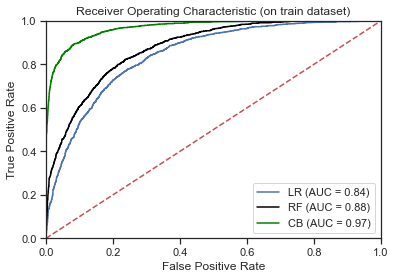

In [142]:
plt.title('Receiver Operating Characteristic (on train dataset)')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'LR (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'black', label = 'RF (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_cb, tpr_cb, 'green', label = 'CB (AUC = %0.2f)' % roc_auc_cb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
sns.set(font_scale = 1)

### Feature importance

#### LR and RF

In [143]:
feature_importance = pd.DataFrame(abs(grid_search_lr.best_estimator_.named_steps["clf"].coef_[0]),
                                     index =  grid_search_lr.best_estimator_.named_steps["prep"]['Transform'].get_feature_names_out(),
                                     columns = ['Importance']).reset_index()

feature_importance['Type_of_model'] = 'LR'

In [144]:
feature_importance_rf = pd.DataFrame(grid_search_rf.best_estimator_.named_steps["clf"].feature_importances_,
                                     index =  grid_search_rf.best_estimator_.named_steps["prep"]['Transform'].get_feature_names_out(),
                                     columns = ['Importance']).reset_index()

feature_importance_rf['Type_of_model'] = 'RF'


In [145]:
feature_importance = feature_importance.append(feature_importance_rf)

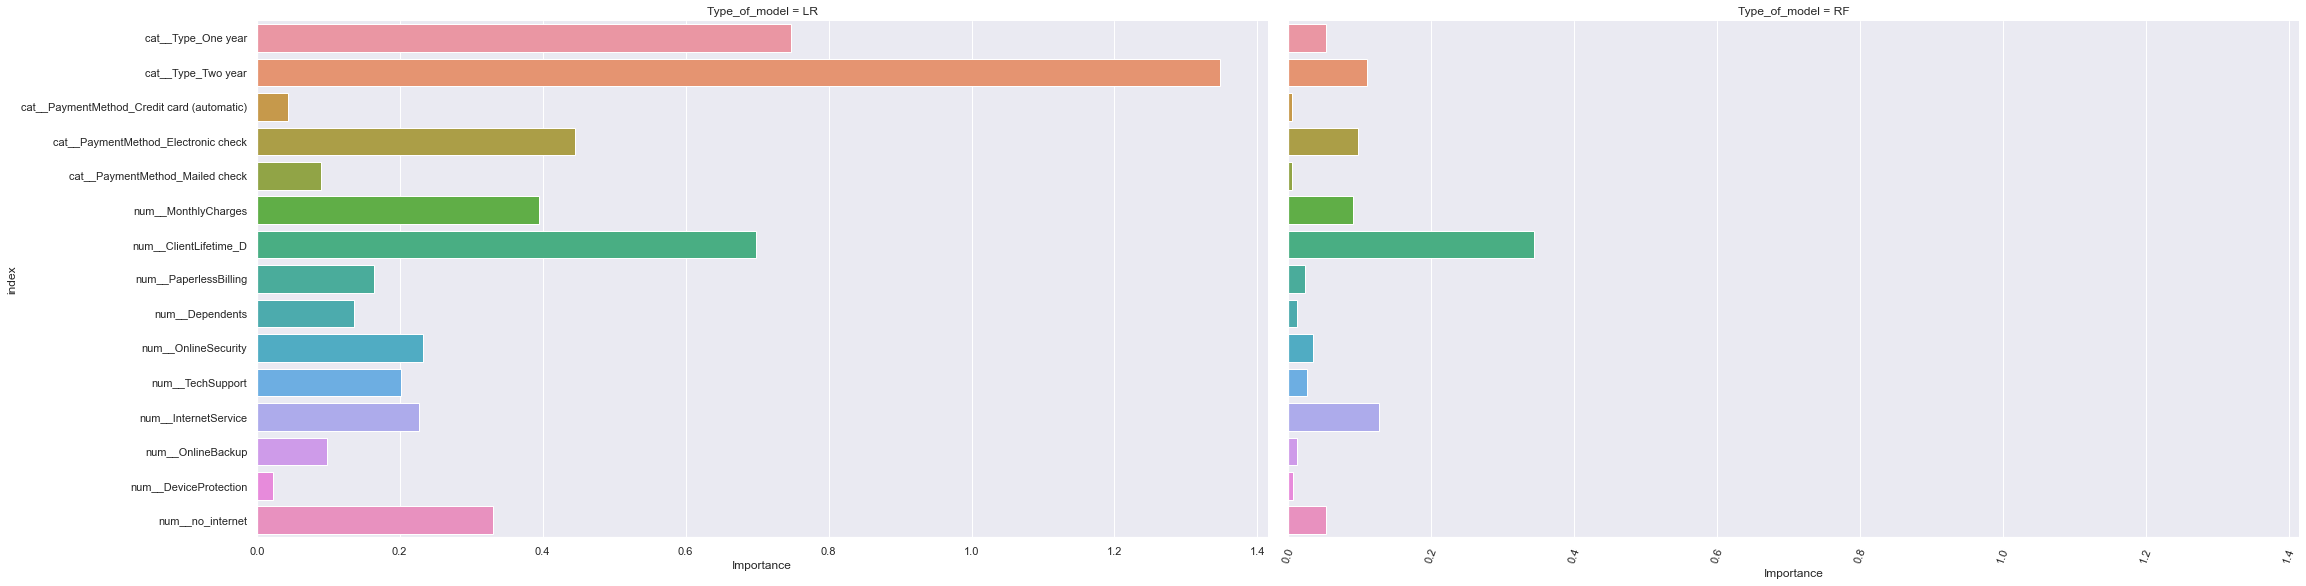

In [146]:
sns.catplot(x="Importance", y="index", col="Type_of_model", kind="bar", 
            height=8, aspect=2, data=feature_importance)
degrees = 70
plt.xticks(rotation = degrees)
sns.set(font_scale = 2)

#### Catboost

In [147]:
feature_importance_cb = model_cb.get_feature_importance(prettified=True)

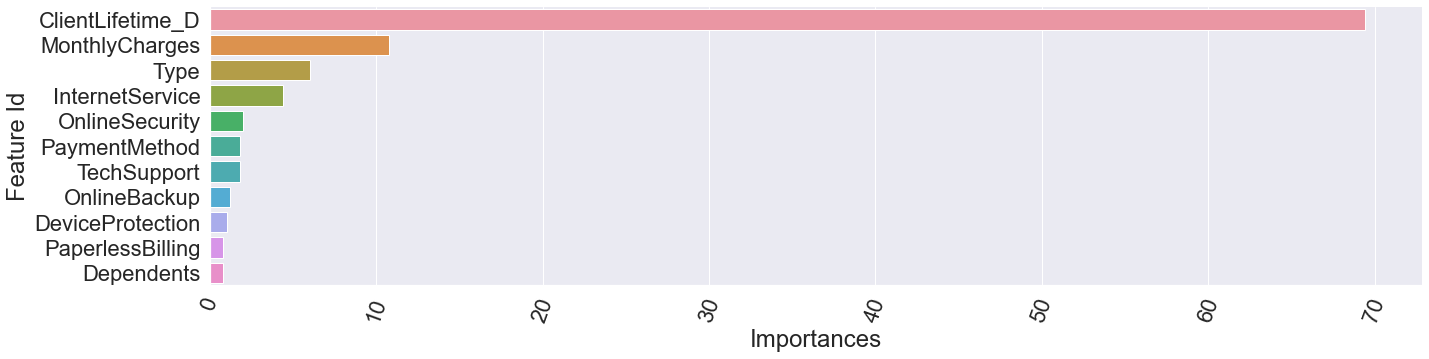

In [148]:
sns.catplot(y="Feature Id", x="Importances", kind="bar", 
            height=5, aspect=4, data=feature_importance_cb)
degrees = 70
plt.xticks(rotation = degrees)
sns.set(font_scale = 1)

# Проверка моделей на тестовой выборке

In [149]:
final_predictions_lr = grid_search_lr.predict_proba(X_test)[:,1]
roc_auc_lr_test_all_f = round(roc_auc_score(y_test, final_predictions_lr),3)

In [150]:
final_predictions_rf = grid_search_rf.predict_proba(X_test)[:,1]
roc_auc_rf_test_all_f = round(roc_auc_score(y_test, final_predictions_rf),3)

In [151]:
test_pool = Pool(data=X_test_cb, label=y_test, cat_features = 
                  X_test_cb.select_dtypes(include=['object']).columns.tolist())

In [152]:
final_predictions_cb = model_cb.predict_proba(test_pool)[:,1]
roc_auc_cb_test_all_f = round(roc_auc_score(y_test, final_predictions_cb),3)

In [153]:
results = pd.DataFrame([[preprocessor.fit_transform(X_train).shape[1], roc_auc_lr, roc_auc_lr_test_all_f],
                        [preprocessor.fit_transform(X_train).shape[1], roc_auc_rf, roc_auc_rf_test_all_f],
                        [len(X_train_cb.columns), roc_auc_cb, roc_auc_cb_test_all_f]],
                        index=pd.Index(['LR', 'RF', 'CB']), 
                       columns=pd.MultiIndex.from_product([['All features (after EDA & preprocessing)'],['N_of_features', 'Train_score', 'Test_score']]))

results

All features (after EDA & preprocessing)                       
                              N_of_features Train_score Test_score
LR                                       15       0.845      0.831
RF                                       15       0.877      0.851
CB                                       11       0.969      0.927

# Оптимальное кол-во фичей

## На основе обученных выше моделей и feature importance

In [154]:
X_train_prepare  = pd.DataFrame(preprocessor.fit_transform(X_train), columns = col_transform.get_feature_names_out())

In [155]:
X_test_prepare = pd.DataFrame(preprocessor.transform(X_test), columns = col_transform.get_feature_names_out())

### LR


In [156]:
important_features_lr = feature_importance.query('Type_of_model=="LR"').sort_values(by='Importance', ascending=False)['index'].tolist()

In [157]:
def fitting_and_predict (model, X_tr, y_tr, X_te, y_te):
  model.fit(X_tr, y_tr)
  predictions_tr =  model.predict_proba(X_tr)[:,1]
  predictions_te = model.predict_proba(X_te)[:,1]
  return  round(roc_auc_score(y_tr, predictions_tr),3), round(roc_auc_score(y_te, predictions_te),3)

In [158]:
features_for_learn_lr = []
num_of_features_lr=[]
roc_auc_lr_train = []
roc_auc_lr_test = []

model_lr = LogisticRegression(C=1)
for feature in important_features_lr:
  features_for_learn_lr.append(feature)
  num_of_features_lr.append(len(features_for_learn_lr))
  scores = fitting_and_predict (model_lr, X_train_prepare[features_for_learn_lr], y_train, X_test_prepare[features_for_learn_lr], y_test)
  roc_auc_lr_train.append(scores[0])
  roc_auc_lr_test.append(scores[1])
 

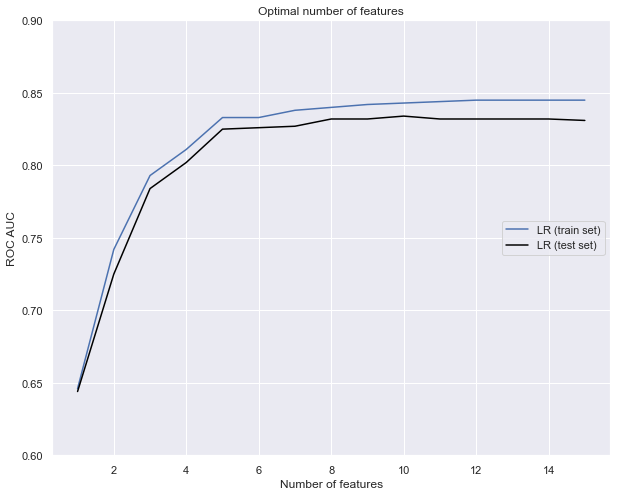

In [159]:
plt.figure(figsize=(10,8))
plt.title('Optimal number of features')
plt.plot(num_of_features_lr, roc_auc_lr_train, 'b', label = 'LR (train set)')
plt.plot(num_of_features_lr, roc_auc_lr_test, 'black', label = 'LR (test set)')
plt.legend(loc = 'center right')
plt.ylim([0.6, 0.9])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features')
plt.show()
sns.set(font_scale = 1)

In [160]:
num_of_features_lr_opt = 10
important_features_lr[0:10]

['cat__Type_Two year',
 'cat__Type_One year',
 'num__ClientLifetime_D',
 'cat__PaymentMethod_Electronic check',
 'num__MonthlyCharges',
 'num__no_internet',
 'num__OnlineSecurity',
 'num__InternetService',
 'num__TechSupport',
 'num__PaperlessBilling']

In [161]:
roc_auc_lr_train[9]

0.843

In [162]:
roc_auc_lr_test[9]

0.834

### RF

In [163]:
important_features_rf = feature_importance.query('Type_of_model=="RF"').sort_values(by='Importance', ascending=False)['index'].tolist()

In [164]:
features_for_learn_rf = []
num_of_features_rf=[]
roc_auc_rf_train = []
roc_auc_rf_test = []

model_rf = RandomForestClassifier(max_depth=6, n_estimators = 110, random_state=42)
for feature in important_features_rf:
  features_for_learn_rf.append(feature)
  num_of_features_rf.append(len(features_for_learn_rf))
  scores = fitting_and_predict (model_rf, X_train_prepare[features_for_learn_rf], y_train, X_test_prepare[features_for_learn_rf], y_test)
  roc_auc_rf_train.append(scores[0])
  roc_auc_rf_test.append(scores[1])

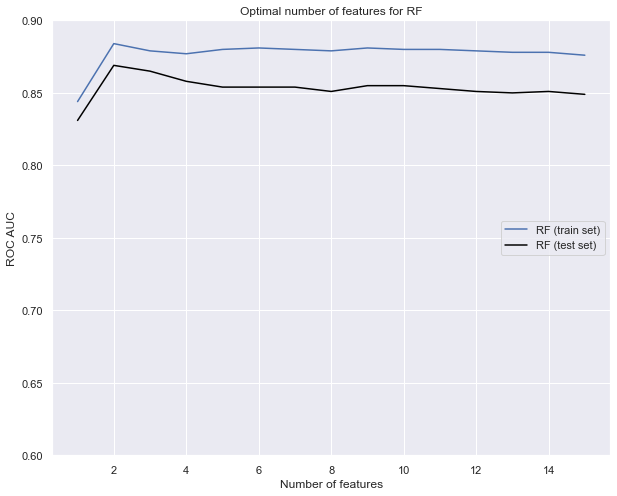

In [165]:
plt.figure(figsize=(10,8))
plt.title('Optimal number of features for RF')
plt.plot(num_of_features_rf, roc_auc_rf_train, 'b', label = 'RF (train set)')
plt.plot(num_of_features_rf, roc_auc_rf_test, 'black', label = 'RF (test set)')
plt.legend(loc = 'center right')
plt.ylim([0.6, 0.9])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features')
plt.show()
sns.set(font_scale = 1)

In [166]:
num_of_features_rf_opt = 5
important_features_rf[0:5]

['num__ClientLifetime_D',
 'num__InternetService',
 'cat__Type_Two year',
 'cat__PaymentMethod_Electronic check',
 'num__MonthlyCharges']

In [167]:
roc_auc_rf_train[4]

0.88

In [168]:
roc_auc_rf_test[4]

0.854

### Catboost

In [169]:
important_features_cb = model_cb.get_feature_importance(prettified=True)['Feature Id'].tolist()
important_features_cb

['ClientLifetime_D',
 'MonthlyCharges',
 'Type',
 'InternetService',
 'OnlineSecurity',
 'PaymentMethod',
 'TechSupport',
 'OnlineBackup',
 'DeviceProtection',
 'PaperlessBilling',
 'Dependents']

In [170]:
features_for_learn_cb = []
num_of_features_cb=[]
roc_auc_cb_train = []
roc_auc_cb_test = []

test_pool = Pool(data=X_test_cb, label=y_test, cat_features = 
                  X_test_cb.select_dtypes(include=['object']).columns.tolist())

#model_cb = RandomForestClassifier(max_depth=6, n_estimators = 110, random_state=42)
for feature in important_features_cb:
  features_for_learn_cb.append(feature)
  num_of_features_cb.append(len(features_for_learn_cb))

  train_pool = Pool(data=X_train_cb[features_for_learn_cb], label=y_train, cat_features = 
                  X_train_cb[features_for_learn_cb].select_dtypes(include=['object']).columns.tolist())

  test_pool = Pool(data=X_test_cb[features_for_learn_cb], label=y_test, cat_features = 
                  X_test_cb[features_for_learn_cb].select_dtypes(include=['object']).columns.tolist())

  model_cb.fit(train_pool)
  roc_auc_cb_train.append(round(roc_auc_score(y_train,model_cb.predict_proba(train_pool)[:,1]),3))
  roc_auc_cb_test.append(round(roc_auc_score(y_test,model_cb.predict_proba(test_pool)[:,1]),3))

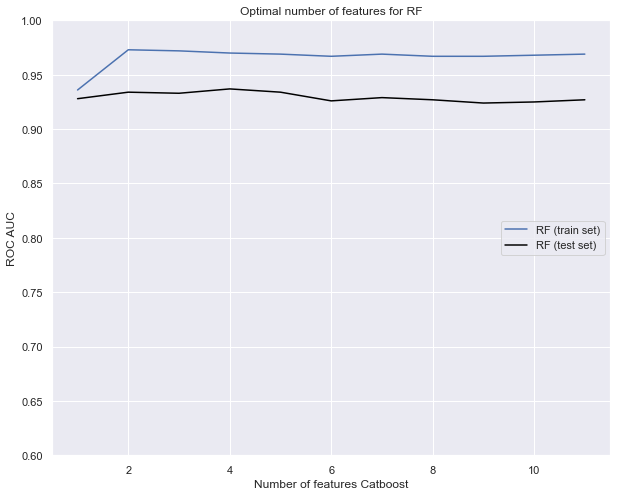

In [171]:
plt.figure(figsize=(10,8))
plt.title('Optimal number of features for RF')
plt.plot(num_of_features_cb, roc_auc_cb_train, 'b', label = 'RF (train set)')
plt.plot(num_of_features_cb, roc_auc_cb_test, 'black', label = 'RF (test set)')
plt.legend(loc = 'center right')
plt.ylim([0.6, 1])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features Catboost')
plt.show()
sns.set(font_scale = 1)

In [172]:
num_of_features_cb_opt = 2
important_features_cb[0:2]

['ClientLifetime_D', 'MonthlyCharges']

In [173]:
roc_auc_cb_train[1]

0.973

In [174]:
roc_auc_cb_test[1]

0.934

In [225]:
optimum_result = pd.DataFrame([[num_of_features_lr_opt, roc_auc_lr_train[num_of_features_lr_opt-1], roc_auc_lr_test[num_of_features_lr_opt-1]],
                        [num_of_features_rf_opt, roc_auc_rf_train[num_of_features_rf_opt-1], roc_auc_rf_test[num_of_features_lr_opt-1]],
                        [num_of_features_cb_opt, roc_auc_cb_train[num_of_features_cb_opt-1], roc_auc_cb_test[num_of_features_lr_opt-1]]],
                        index=pd.Index(['LR', 'RF', 'CB']), 
                       columns=pd.MultiIndex.from_product([['Optimum number of features'],['N_of_features', 'Train_score', 'Test_score']]))

optimum_result

Optimum number of features                       
                N_of_features Train_score Test_score
LR                         10       0.843      0.834
RF                          5       0.880      0.855
CB                          2       0.973      0.925

# Анализ результатов

In [9]:
final =  results.join(optimum_result)
final

NameError: name 'results' is not defined